<a href="https://colab.research.google.com/github/calebmckay1/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [0]:
### begin ###

In [0]:
import warnings
warnings.filterwarnings("ignore")

## added this because the runtime warnings were annoying lol

In [7]:
print(df.shape)
df.head()

(23040, 21)


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df2 = df[df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS']

### extracted the data that has building class category '01 one family dwelling
## and added it to a new dataframe called df2

In [0]:
df2 = df2[df2['SALE_PRICE'] < 2000000]

### from that data i replaced it with one family dwellings that are priced at less
## than 2,000,000

In [0]:
df2 = df2[df2['SALE_PRICE'] > 100000]

### from that data i replaced it with one family dwelling that is priced less than
## 2,000,000 but more than 100,000

In [11]:
df2.shape

## looks like we have same amount of columns but significantly reduced number of
# rows 

(3151, 21)

In [12]:
df2.describe()

## looks like min sale price is $104,000 and max is $1,955,000 cool

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,3151.000000,3151.000000,0.0,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.000000,3151.0,3.151000e+03
mean,6917.976515,75.981593,NaN,11027.219613,0.987623,0.015868,1.003491,1470.306887,1943.694700,1.0,6.285601e+05
std,3963.326705,161.089514,NaN,482.875284,0.113414,0.127499,0.171789,586.339200,26.676786,0.0,2.929904e+05
min,21.000000,1.000000,NaN,10030.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,4016.000000,21.000000,NaN,10461.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.475000e+05
50%,6301.000000,42.000000,NaN,11235.000000,1.000000,0.000000,1.000000,1360.000000,1938.000000,1.0,5.680000e+05
75%,10208.500000,69.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1683.000000,1955.000000,1.0,7.600000e+05
max,16350.000000,2720.000000,NaN,11697.000000,2.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [0]:
df2['SALE_DATE']= pd.to_datetime(df2['SALE_DATE']) 

### converted sale date to datetime to seperate the data by sale date later

In [0]:
train = df2[df2['SALE_DATE'] >= '2019-01-01']
test = df2[df2['SALE_DATE'] >= '2019-04-01']

train = train[train['SALE_DATE'] <= '2019-03-31']
test = test[test['SALE_DATE'] <= '2019-04-30']

### there's probably an easier way to do this but seperated the df2 by date into
### 2 seperate datasets called train and test

In [15]:
train.describe(exclude='number')

### viewed cloumns to one-hot encode

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2507,2507,2507,2507,2507,2507,1,2507,2507,2507
unique,5,6,1,2,13,2497,1,887,11,68
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,118-20 202ND STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1204,2382,2507,2476,919,2,1,234,919,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [16]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean().sort_values()

## viewed the relationship between price and neighborhood, looks like
## forest hills is the most expensive with east new york being least expensive

NEIGHBORHOOD
OTHER                 6.056645e+05
BEDFORD STUYVESANT    6.215972e+05
FLUSHING-NORTH        8.689417e+05
ASTORIA               1.001955e+06
BOROUGH PARK          1.008917e+06
FOREST HILLS          1.210753e+06
Name: SALE_PRICE, dtype: float64

In [17]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'SALE_DATE','EASE-MENT']
features = train.columns.drop([target] + high_cardinality)
features


### dropped the columns in high_cardinality because they have high amount 
### unique values, and the target(sale price) to one-hot encode the 
### the remaining columns.

## had to remove ease-ment alsoo because it had nan values later found

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'APARTMENT_NUMBER', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [0]:
x_train = train[features]
y_train = train[target]
x_test = test[features]
y_test = test[target]

## created x & y axis for test and train, using features for x and sale price
## (our target) for y 

In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
x_train = encoder.fit_transform(x_train)

In [0]:
x_test = encoder.transform(x_test)

In [21]:
x_test

## ohh that's cool, alot easier than i thought to one-hot encode lol

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,APARTMENT_NUMBER_nan,APARTMENT_NUMBER_RP.,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18235,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5913,878,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,10471.0,1.0,0.0,1.0,2272.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
18239,0,0,1,0,0,1,0,0,0,0,0,1,1,0,5488,48,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,10465.0,1.0,0.0,1.0,720.0,1935.0,1,0,0,0,0,1,0,0,0,0,0,0
18244,1,0,0,0,0,1,0,0,0,0,0,1,1,0,5936,31,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11209.0,1.0,0.0,1.0,2210.0,1925.0,1,0,1,0,0,0,0,0,0,0,0,0
18280,1,0,0,0,0,1,0,0,0,0,0,1,1,0,7813,24,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,11210.0,1.0,0.0,1.0,1520.0,1915.0,1,0,0,1,0,0,0,0,0,0,0,0
18285,1,0,0,0,0,1,0,0,0,0,0,1,1,0,8831,160,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,11229.0,1.0,0.0,1.0,840.0,1925.0,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,0,1,0,0,0,1,0,0,0,0,0,1,1,0,13215,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,11422.0,1.0,0.0,1.0,1478.0,1925.0,1,0,0,0,0,1,0,0,0,0,0,0
23031,0,1,0,0,0,1,0,0,0,0,0,1,1,0,11612,73,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11420.0,1.0,0.0,1.0,1280.0,1930.0,1,0,1,0,0,0,0,0,0,0,0,0
23032,0,1,0,0,0,1,0,0,0,0,0,1,1,0,11808,50,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,11420.0,1.0,0.0,1.0,1333.0,1945.0,1,0,0,0,1,0,0,0,0,0,0,0
23033,0,1,0,0,0,1,0,0,0,0,0,1,1,0,12295,23,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,11434.0,1.0,0.0,1.0,1020.0,1935.0,1,0,1,0,0,0,0,0,0,0,0,0


In [0]:
from sklearn.feature_selection import SelectKBest, f_regression

the_selector = SelectKBest(score_func=f_regression, k=20)

In [0]:
x_train_selected = the_selector.fit_transform(x_train, y_train)
x_test_selected = the_selector.fit_transform(x_test, y_test)

In [24]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0],normalize=True)
ridge.fit(x_train, y_train)
ridge.alpha_

## looks like 0.001 is best alpha? 

0.001

In [28]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    display(f'Ridge Regression, with alpha={alpha}')
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    mae = mean_absolute_error(y_test, y_pred)
    display(f'Test Mean Absolute Error: ${mae:,.0f}')

### looks like alpha is actually best if its 0.1. Very confused rn. 

'Ridge Regression, with alpha=0.001'

'Test Mean Absolute Error: $159,511'

'Ridge Regression, with alpha=0.01'

'Test Mean Absolute Error: $159,148'

'Ridge Regression, with alpha=0.1'

'Test Mean Absolute Error: $159,130'

'Ridge Regression, with alpha=1.0'

'Test Mean Absolute Error: $172,905'

'Ridge Regression, with alpha=1'

'Test Mean Absolute Error: $172,905'

'Ridge Regression, with alpha=100.0'

'Test Mean Absolute Error: $210,164'

'Ridge Regression, with alpha=1000.0'

'Test Mean Absolute Error: $211,420'

In [29]:
for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    display(f'Ridge Regression, with alpha={alpha}')
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(x_train_selected, y_train)
    y_pred = model.predict(x_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    display(f'Test Mean Absolute Error: ${mae:,.0f}')
    
    
### how is SelectKBest and ridge regression related because whenever i input 
### the selected version of test/train it outputs outrageous mae's

'Ridge Regression, with alpha=0.001'

'Test Mean Absolute Error: $4,672,172,050'

'Ridge Regression, with alpha=0.01'

'Test Mean Absolute Error: $3,804,123,577'

'Ridge Regression, with alpha=0.1'

'Test Mean Absolute Error: $1,399,252,126'

'Ridge Regression, with alpha=1.0'

'Test Mean Absolute Error: $620,858,491'

'Ridge Regression, with alpha=1'

'Test Mean Absolute Error: $620,858,491'

'Ridge Regression, with alpha=100.0'

'Test Mean Absolute Error: $52,097,141'

'Ridge Regression, with alpha=1000.0'

'Test Mean Absolute Error: $5,382,080'

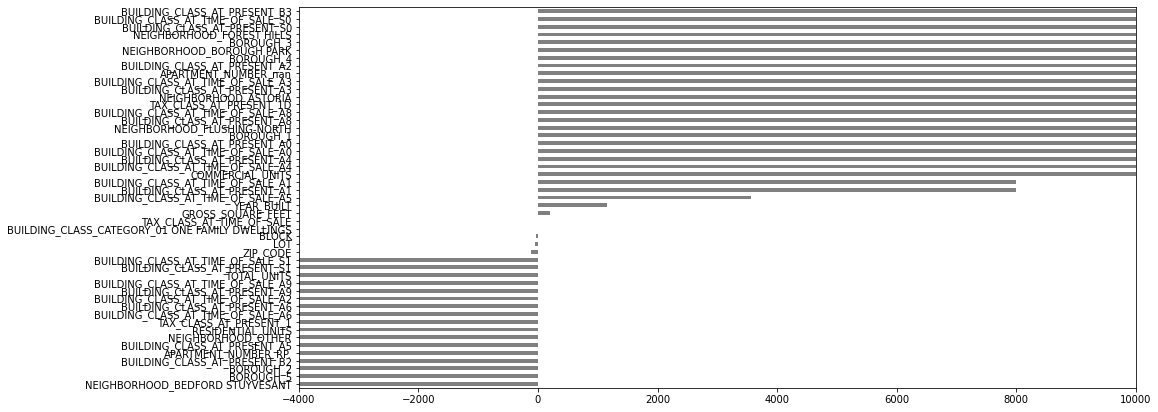

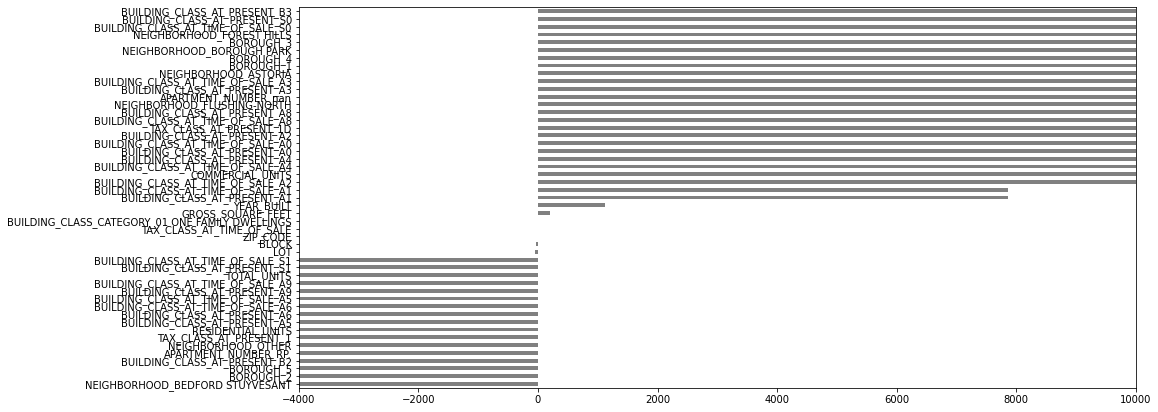

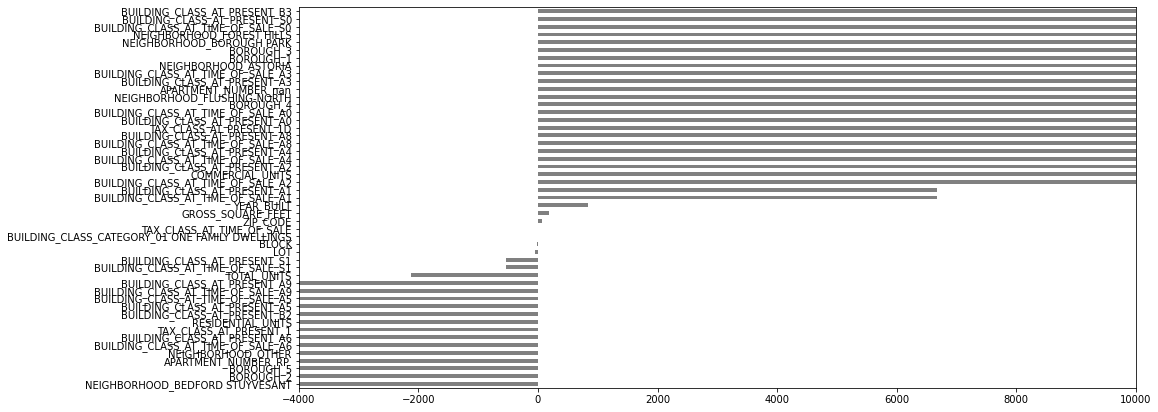

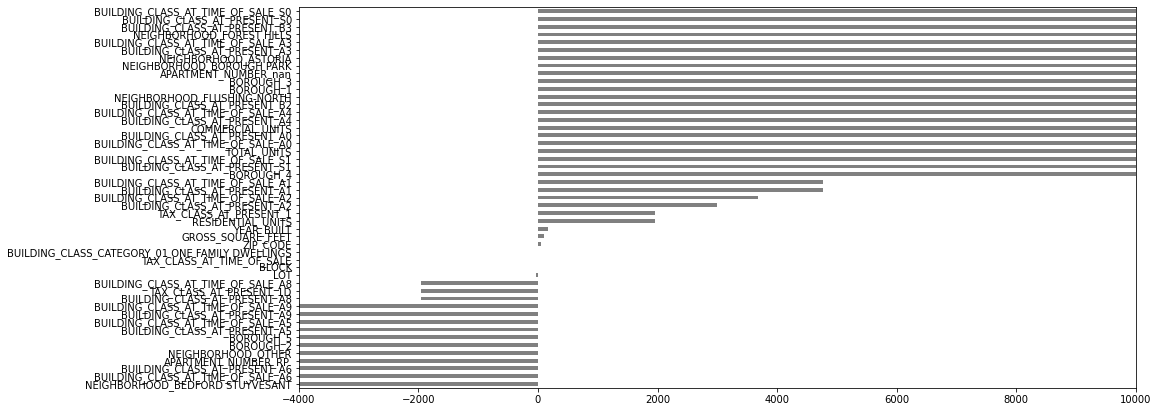

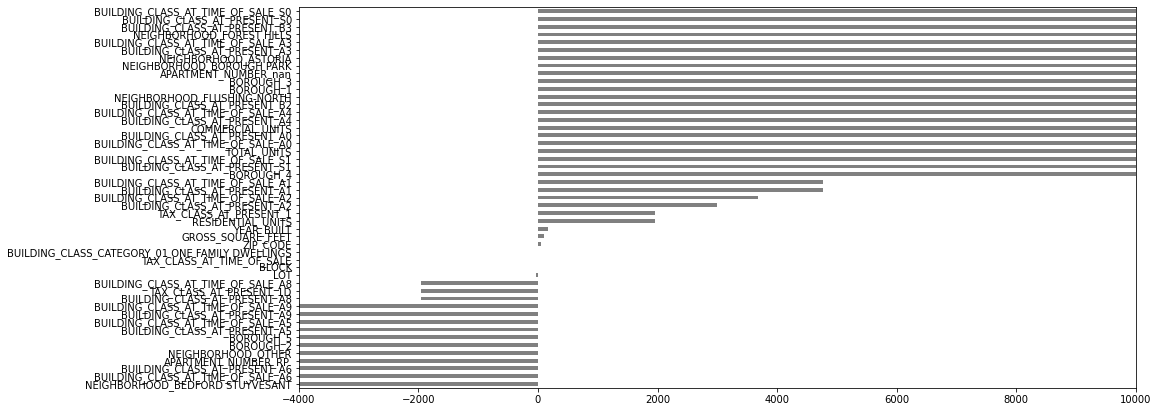

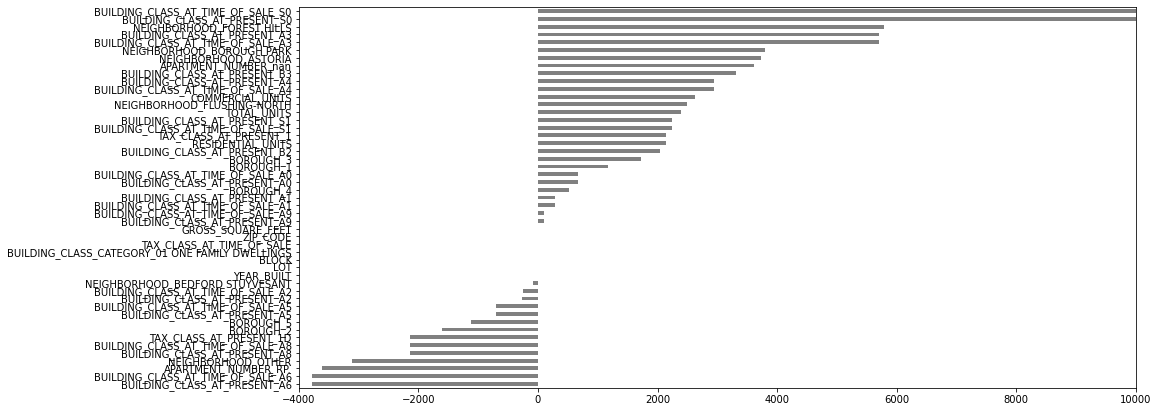

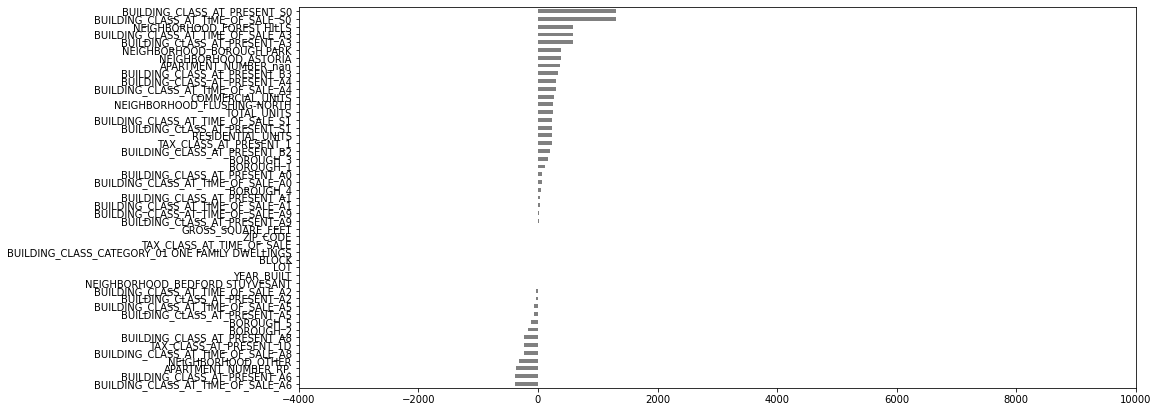

In [30]:
from IPython.display import display, HTML
%matplotlib inline
import matplotlib.pyplot as plt

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, x_train.columns)
    plt.figure(figsize=(15,7))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-4000,10000)
    plt.show();

## had to use matplotlib inline to display plots